In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [6]:
# Cargar datos
dataTraining = pd.read_csv('../datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('../datasets/dataTest_carListings.zip', index_col=0)

dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


,Year,Mileage
count,100000.000000,1.000000e+05
mean,2013.193370,5.509030e+04
std,3.281366,4.096127e+04
min,1997.000000,5.000000e+00
25%,2012.000000,2.589800e+04
50%,2014.000000,4.312800e+04
75%,2016.000000,7.731525e+04
max,2018.000000,1.428913e+06


Cuenta de valores nulos


Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

Valores únicos por columna


Price       35867
Year           22
Mileage    130600
State          51
Make           38
Model         525
dtype: int64

Year          22
Mileage    66697
State         51
Make          37
Model        525
dtype: int64

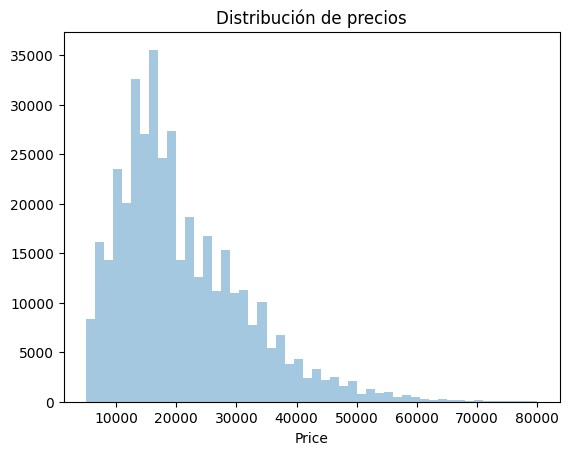

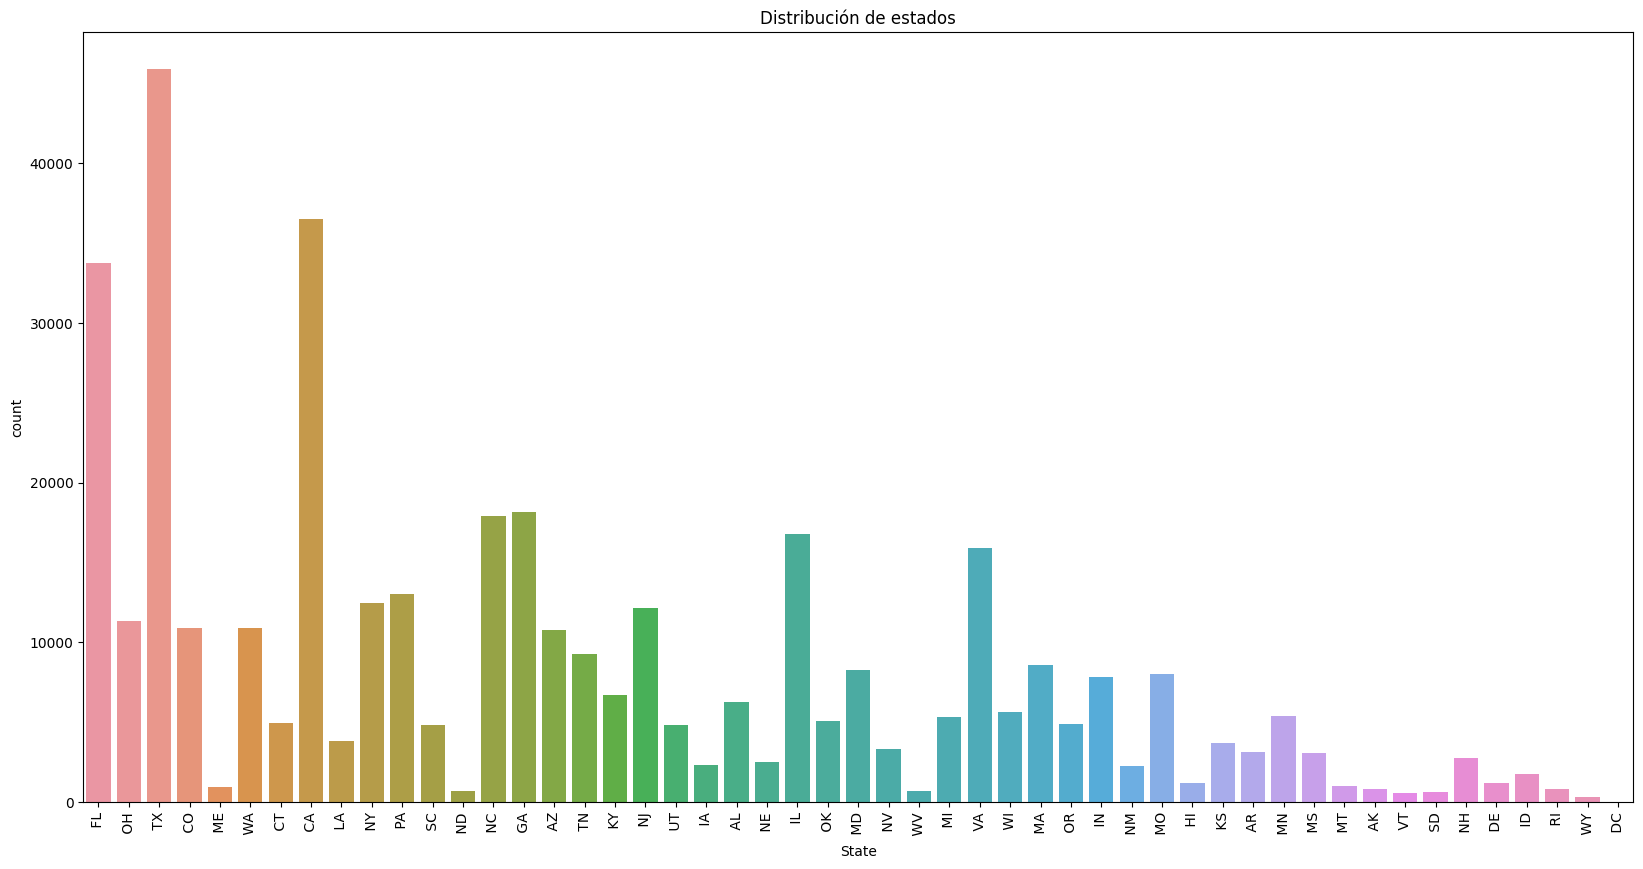

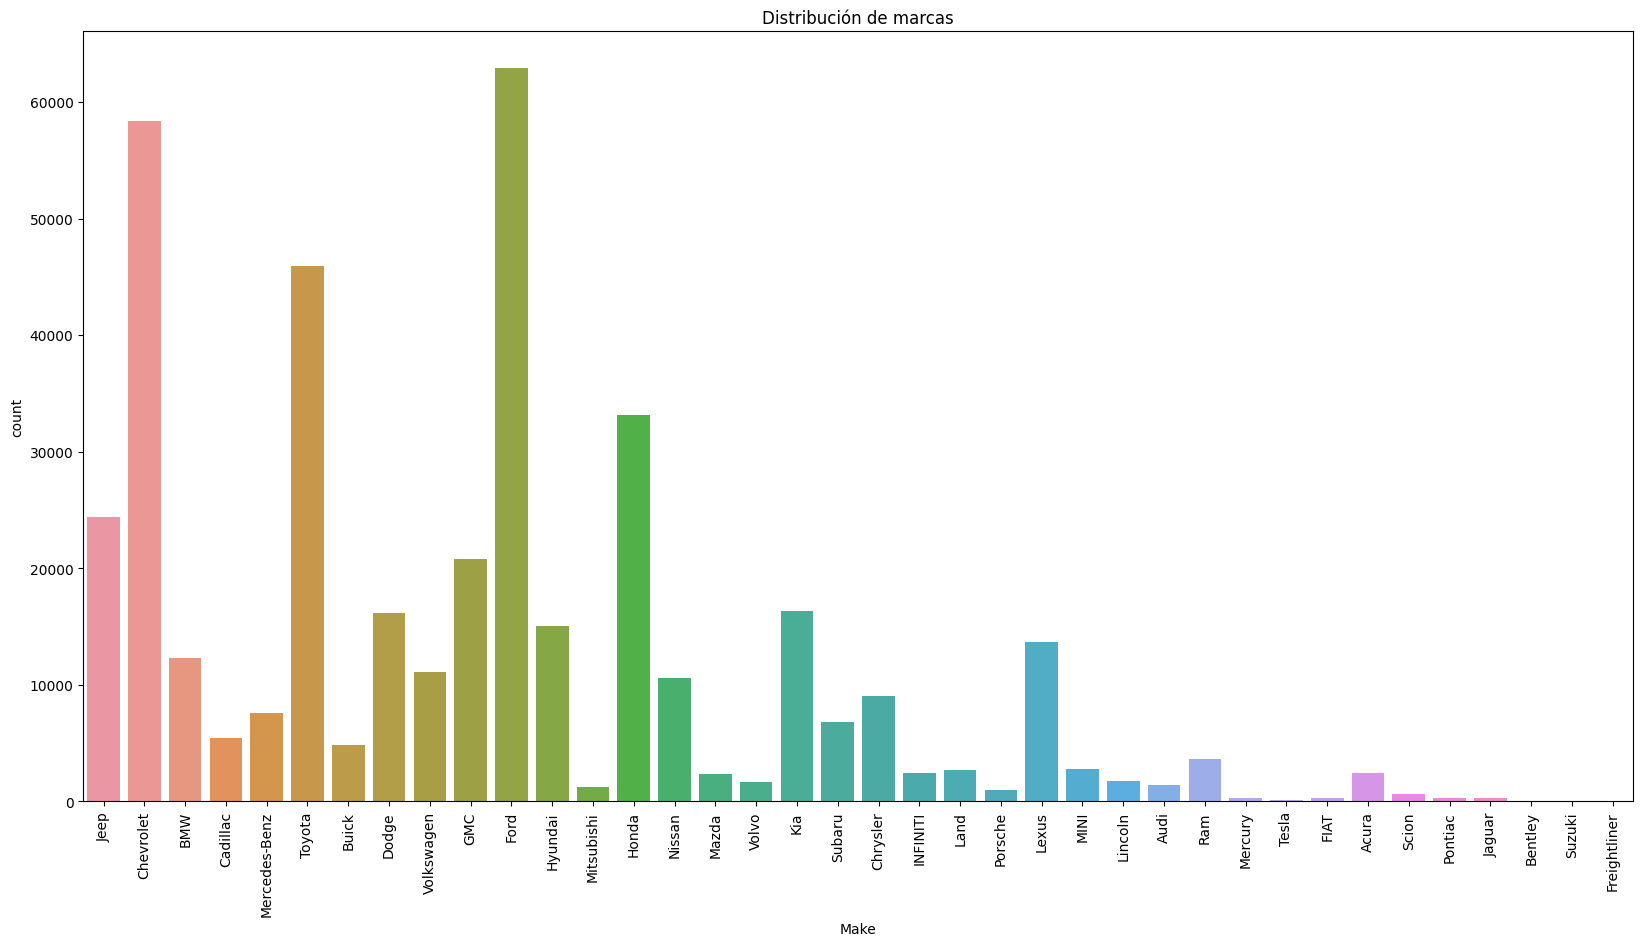

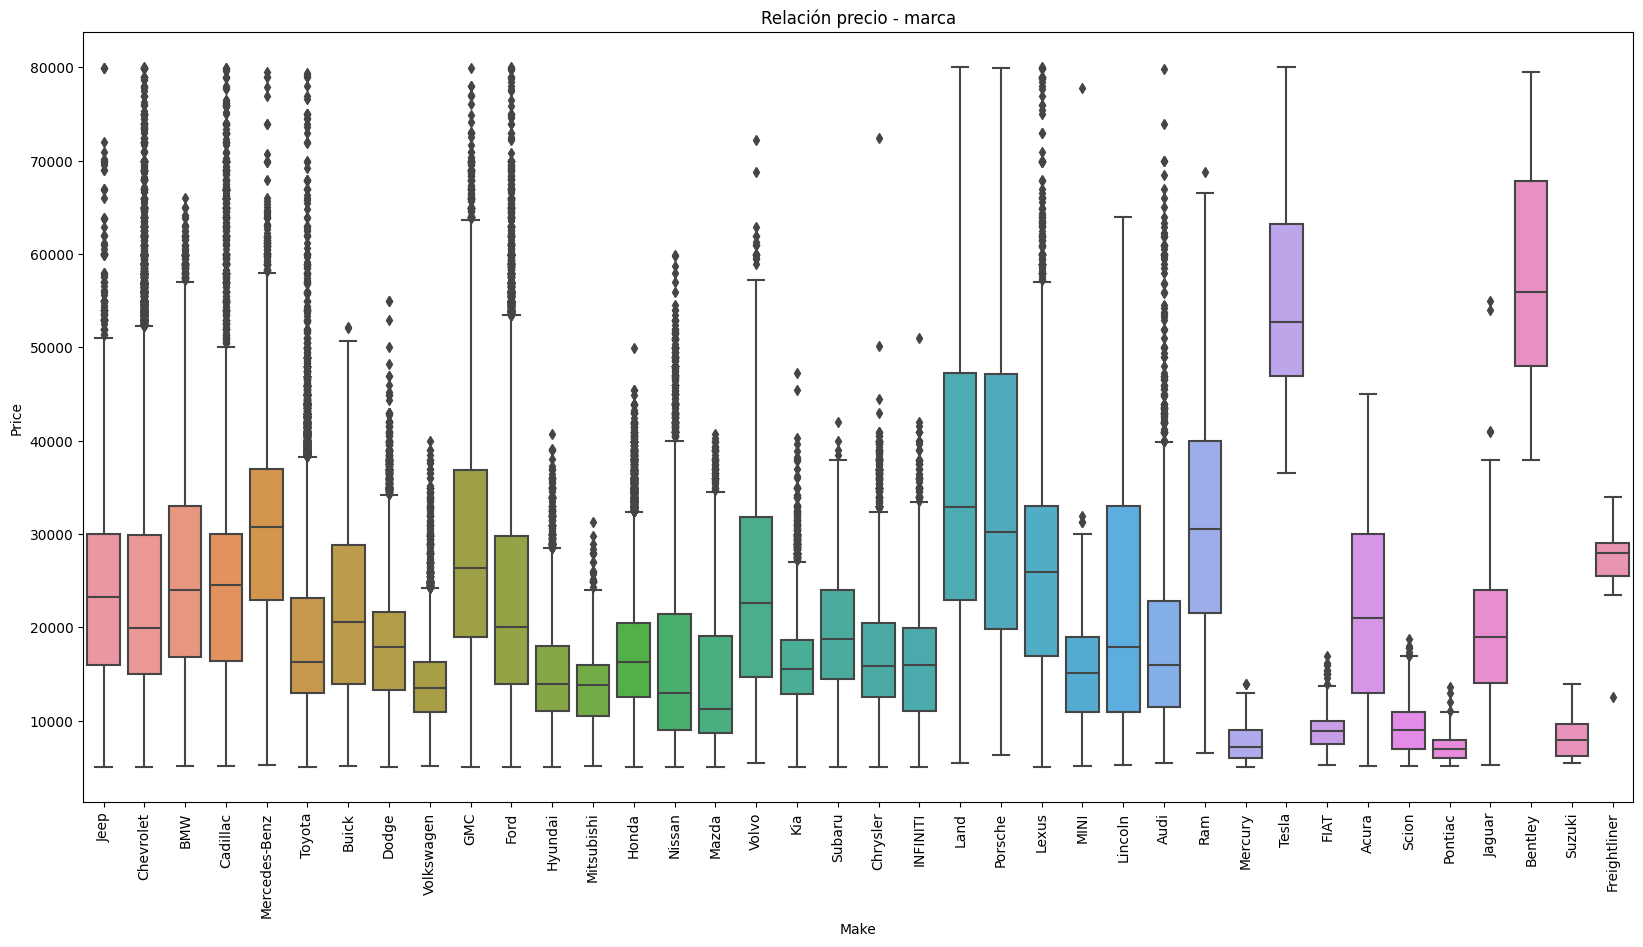

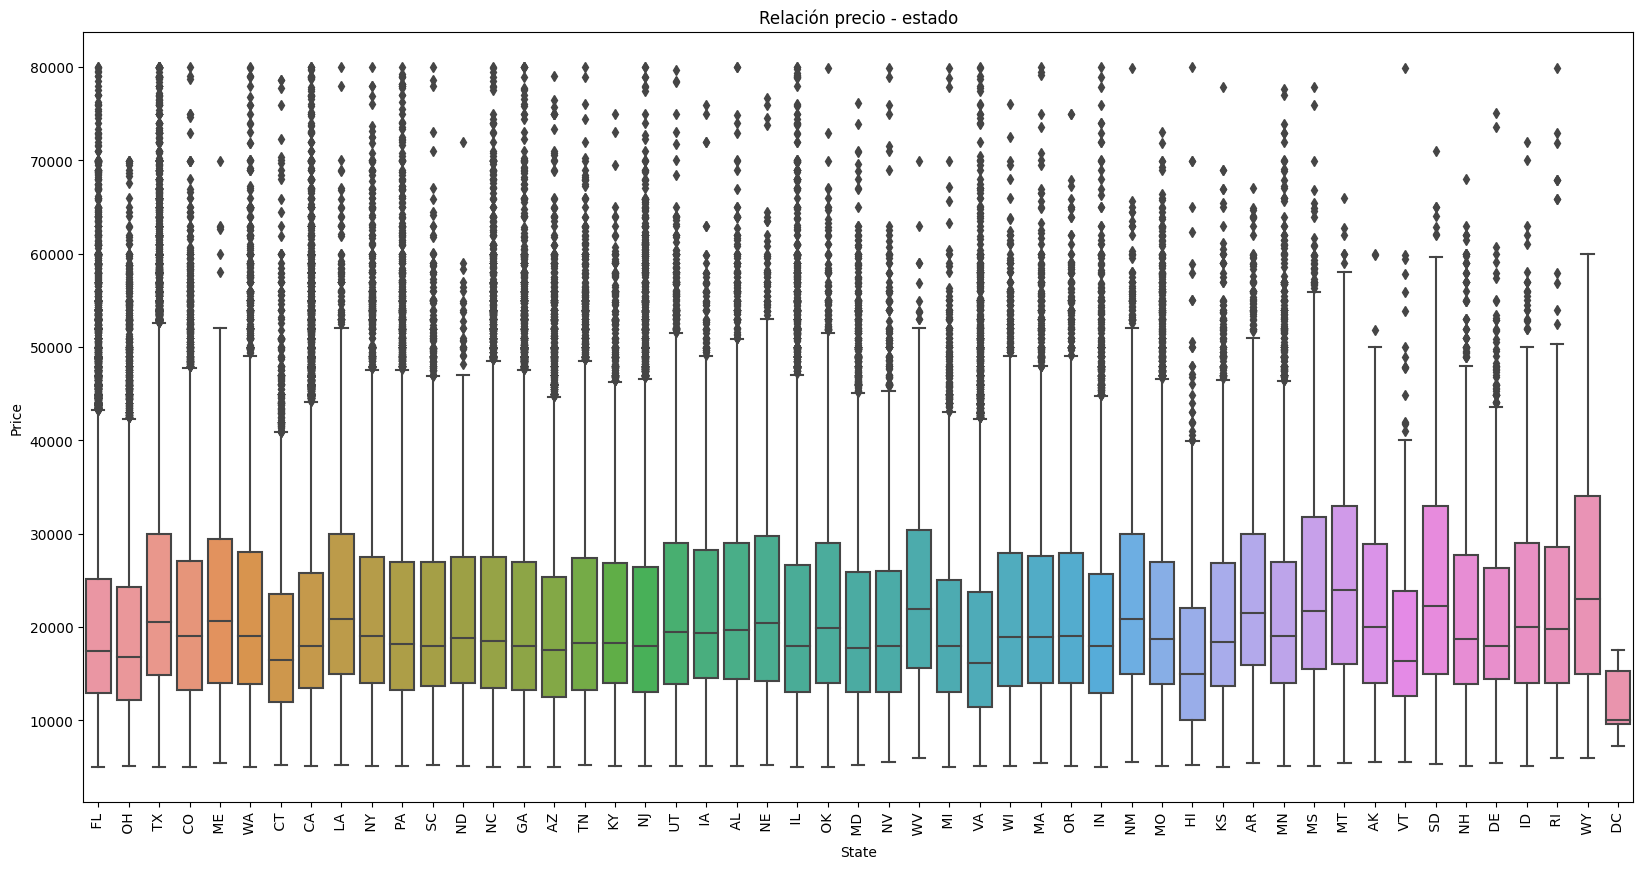

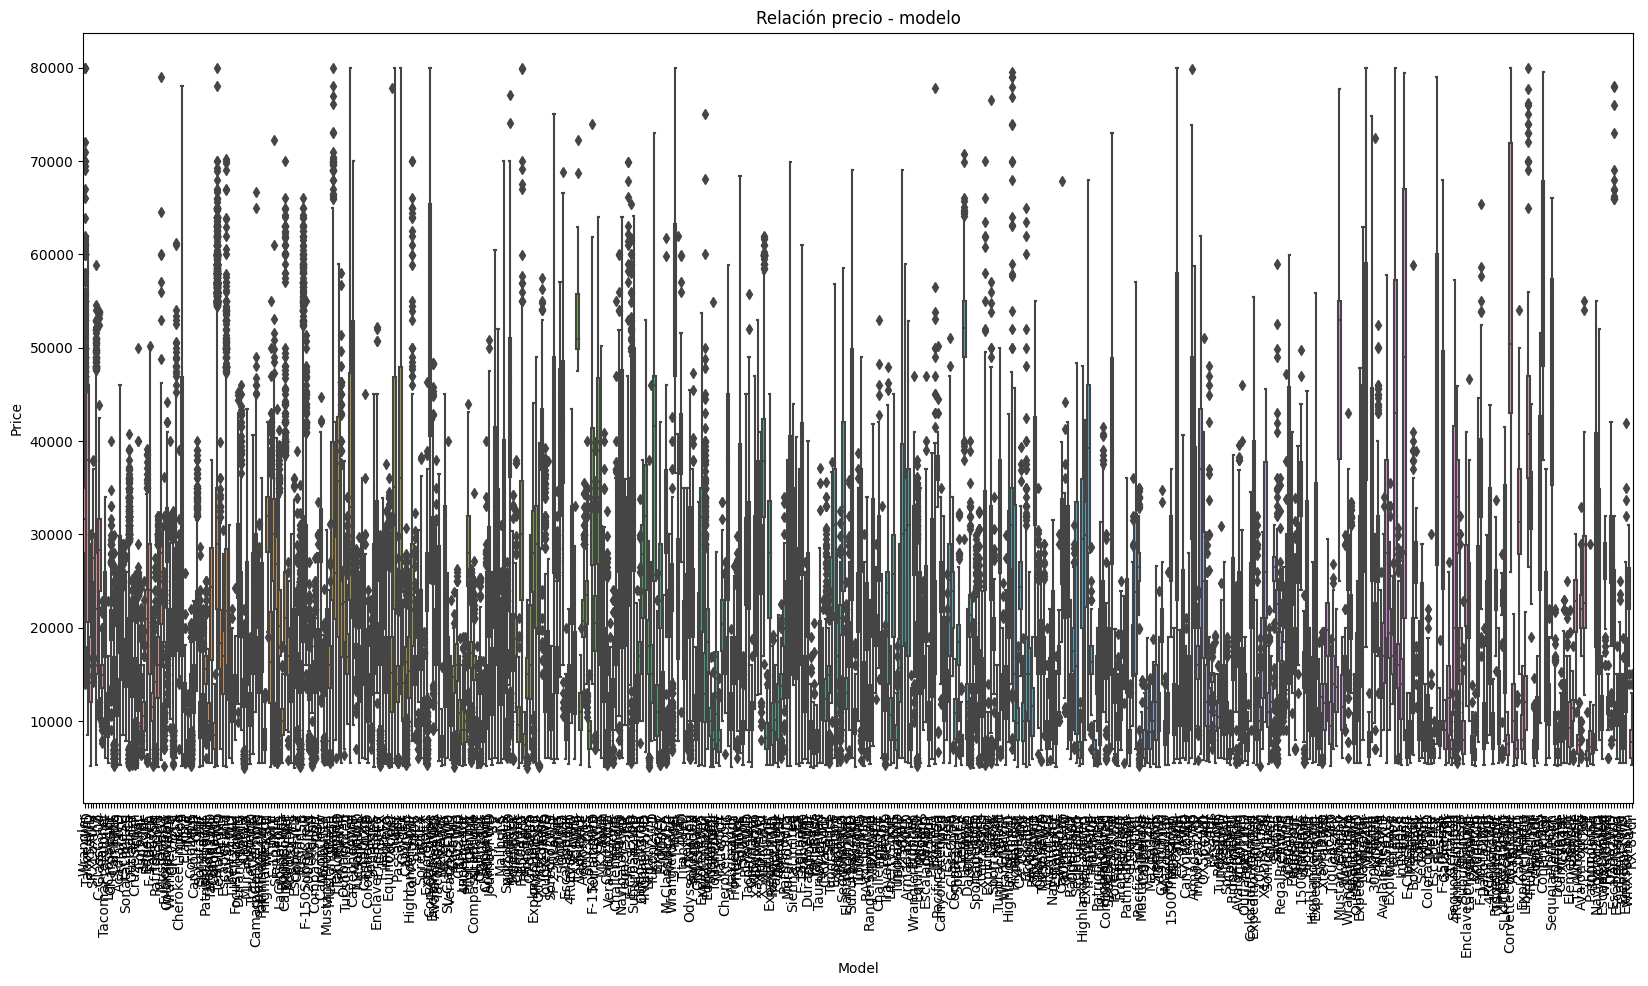

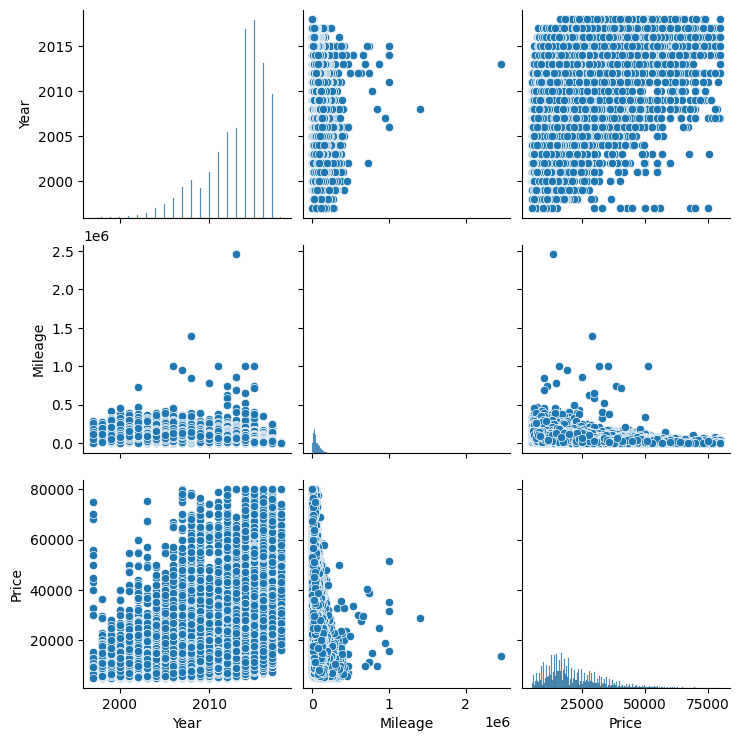

In [7]:
# Análisis descriptivo
display(dataTraining.describe())
display(dataTesting.describe())

# Análisis de valores nulos
print('Cuenta de valores nulos')
display(dataTraining.isnull().sum())
display(dataTesting.isnull().sum())

# Análisis de valores únicos por columna
print('Valores únicos por columna')
display(dataTraining.nunique(axis=0))
display(dataTesting.nunique(axis=0))

# Gráfica de distribución de precios
sns.distplot(dataTraining['Price'], kde=False, bins=50)
plt.title('Distribución de precios')
plt.show()

# Gráfica de distribución de estados
plt.figure(figsize=(20, 10))
sns.countplot(x='State', data=dataTraining)
plt.xticks(rotation=90)
plt.title('Distribución de estados')
plt.show()

# Gráfica para distribución de marcas
plt.figure(figsize=(20, 10))
sns.countplot(x='Make', data=dataTraining)
plt.xticks(rotation=90)
plt.title('Distribución de marcas')
plt.show()

# Gráfica de relación precio - marca
plt.figure(figsize=(20, 10))
sns.boxplot(x='Make', y='Price', data=dataTraining)
plt.xticks(rotation=90)
plt.title('Relación precio - marca')
plt.show()

# Gráfica de relación precio - estado
plt.figure(figsize=(20, 10))
sns.boxplot(x='State', y='Price', data=dataTraining)
plt.xticks(rotation=90)
plt.title('Relación precio - estado')
plt.show()

# Gráfica de relación precio - modelo
plt.figure(figsize=(20, 10))
sns.boxplot(x='Model', y='Price', data=dataTraining)
plt.xticks(rotation=90)
plt.title('Relación precio - modelo')
plt.show()

# Correlograma relación año - kilometraje - precio
sns.pairplot(dataTraining[['Year', 'Mileage', 'Price']])
plt.show()

In [8]:
# Pre procesar los datos
top10_estados = list(dataTraining['State'].value_counts().head(10).index)

#Agrupar los estados que no estan en el top 15 en un solo estado
dataTraining['State'] = dataTraining['State'].apply(lambda x: x if x in top10_estados else 'Otro')
dataTesting['State'] = dataTesting['State'].apply(lambda x: x if x in top10_estados else 'Otro')

# Convertir variables categóricas
dataTraining['State'] = dataTraining['State'].astype('category')
dataTraining['Make'] = dataTraining['Make'].astype('category')
dataTraining['Model'] = dataTraining['Model'].astype('category')

dataTesting['State'] = dataTesting['State'].astype('category')
dataTesting['Make'] = dataTesting['Make'].astype('category')
dataTesting['Model'] = dataTesting['Model'].astype('category')

# Crear variables dummies
dataTraining = pd.get_dummies(dataTraining, columns=['State', 'Make', 'Model'], drop_first=True)
dataTesting = pd.get_dummies(dataTesting, columns=['State', 'Make', 'Model'])

# Separar la variable objetivo
X_total = dataTraining.drop(['Price', 'Make_Freightliner'], axis=1)
y_total = dataTraining['Price']

# Separar los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=123)

#Función para imprimir métricas
def print_metrics(rmse, mae, r2):
    print('Métricas del modelo:')
    print('RMSE:', rmse)
    print('MAE:', mae)
    print('R2:', r2)

In [9]:
X_total

,Year,Mileage,State_ FL,State_ GA,State_ IL,State_ NC,State_ NJ,State_ NY,State_ PA,State_ TX,...,Model_Yaris4dr,Model_YarisBase,Model_YarisLE,Model_Yukon,Model_Yukon2WD,Model_Yukon4WD,Model_Yukon4dr,Model_tC2dr,Model_xB5dr,Model_xD5dr
0,2017,9913,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2015,20578,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2012,83716,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,2014,28729,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2013,64032,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,2015,25287,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
399996,2015,17677,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
399997,2014,66688,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
399998,2014,37872,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
# Calibración de un modelo de regresión XGBoost
# Definición de parámetros
n_estimators_range = list(range(100, 200, 20))
learning_rate_range = np.linspace(0.01, 0.5, 20, endpoint=True)
max_depth_range = list(range(8, 20, 2))
min_child_weight_range = list(range(28, 37, 2))

# Definición de variables para guardar los resultados
rmse_list = []

# Ciclo para evaluar n_estimators
for n_estimators in n_estimators_range:
    print(f'Probando con n_estimators={n_estimators}')
    # Crear el modelo
    model = XGBRegressor(n_estimators=n_estimators, random_state=123, n_jobs=-1)
    # Entrenar el modelo
    model.fit(X_train, y_train)
    # Predecir
    y_pred = model.predict(X_test)
    # Calcular métricas
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print(f'RMSE={rmse}')
    # Guardar resultados
    rmse_list.append(rmse)


Probando con n_estimators=100
RMSE=4324.44740848686
Probando con n_estimators=120
RMSE=4159.421776754968
Probando con n_estimators=140
RMSE=4043.582896209236
Probando con n_estimators=160
RMSE=3960.209084421923
Probando con n_estimators=180
RMSE=3887.839766319655


El mejor valor de n_estimators es 180
El mejor valor de RMSE es 3887.839766319655


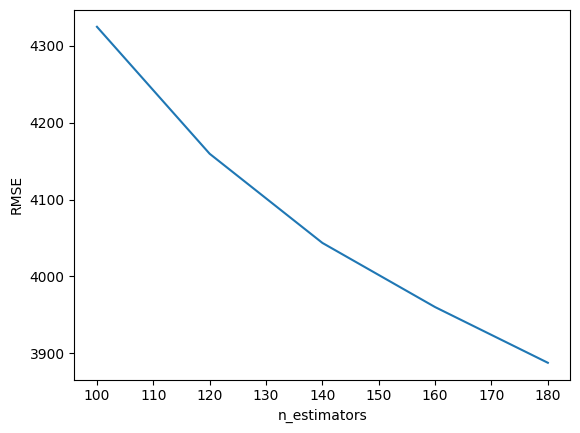

In [12]:
# Mejor n_estimators
n_estimators_best = n_estimators_range[np.argmin(rmse_list)]
print(f'El mejor valor de n_estimators es {n_estimators_best}')

# Mejor error
rmse_best = np.min(rmse_list)
print(f'El mejor valor de RMSE es {rmse_best}')

# Gráfica de RMSE vs n_estimators
plt.plot(n_estimators_range, rmse_list)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

In [13]:
# Calibrar learning rate con mejor n_estimators
n_estimators_best = 220
# Definición de variables para guardar los resultados
rmse_list = []

# Ciclo para evaluar learning_rate
for learning_rate in learning_rate_range:
    print(f'Probando con learning_rate={learning_rate}')
    # Crear el modelo
    model = XGBRegressor(n_estimators=n_estimators_best, learning_rate=learning_rate, random_state=123, n_jobs=-1)
    # Entrenar el modelo
    model.fit(X_train, y_train)
    # Predecir
    y_pred = model.predict(X_test)
    # Calcular métricas
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print(f'RMSE={rmse}')
    # Guardar resultados
    rmse_list.append(rmse)

Probando con learning_rate=0.01


KeyboardInterrupt: 

El mejor valor de learning_rate es 0.21842105263157896
El mejor valor de RMSE es 7313.414880783242


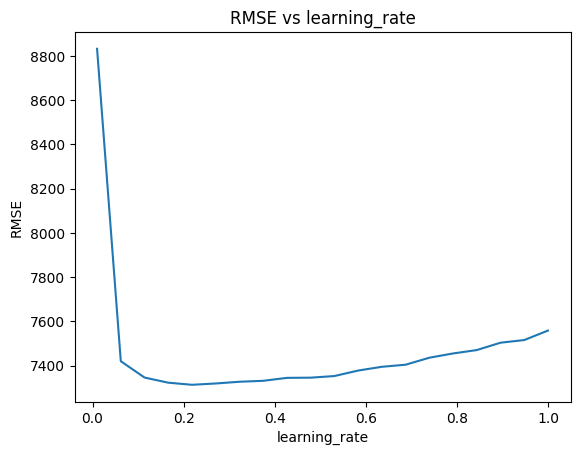

In [9]:
# Mejor learning_rate
learning_rate_best = learning_rate_range[np.argmin(rmse_list)]
print(f'El mejor valor de learning_rate es {learning_rate_best}')
# Mejor error
rmse_best = np.min(rmse_list)
print(f'El mejor valor de RMSE es {rmse_best}')

# Graficar RMSE vs learning_rate
plt.plot(learning_rate_range, rmse_list)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.title('RMSE vs learning_rate')
plt.show()

In [14]:
# Calibración de max_depth
n_estimators_best = 220
# Definición de variables para guardar los resultados
rmse_list = []

# Ciclo para evaluar max_depth
for max_depth in max_depth_range:
    print(f'Probando con max_depth={max_depth}')
    # Crear el modelo
    model = XGBRegressor(n_estimators=n_estimators_best, learning_rate=0.1, max_depth=max_depth, random_state=123, n_jobs=-1)
    # Entrenar el modelo
    model.fit(X_train, y_train)
    # Predecir
    y_pred = model.predict(X_test)
    # Calcular métricas
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print(f'RMSE={rmse}')
    # Guardar resultados
    rmse_list.append(rmse)

Probando con max_depth=8
RMSE=4321.288118775949
Probando con max_depth=10
RMSE=4067.027686460634
Probando con max_depth=12
RMSE=3883.6682303748403
Probando con max_depth=14
RMSE=3776.9025142688506
Probando con max_depth=16
RMSE=3706.261003526243
Probando con max_depth=18
RMSE=3664.2612512076607


El mejor valor de max_depth es 7
El mejor valor de RMSE es 7318.094423560209


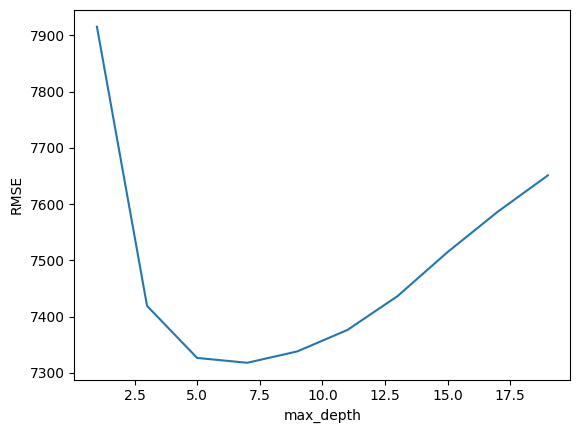

In [11]:
# Mejor max_depth
max_depth_best = max_depth_range[np.argmin(rmse_list)]
print(f'El mejor valor de max_depth es {max_depth_best}')
# Mejor error
rmse_best = np.min(rmse_list)
print(f'El mejor valor de RMSE es {rmse_best}')

# Graficar RMSE vs max_depth
plt.plot(max_depth_range, rmse_list)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()

In [12]:
# Calibrar min_child_weight
min_child_weight_range = list(range(24, 52, 2))
# Definición de variables para guardar los resultados
rmse_list = []

# Ciclo para evaluar min_child_weight
for min_child_weight in min_child_weight_range:
    print(f'Probando con min_child_weight={min_child_weight}')
    # Crear el modelo
    model = XGBRegressor(n_estimators=n_estimators_best, learning_rate=learning_rate_best, max_depth=max_depth_best, min_child_weight=min_child_weight, random_state=123, n_jobs=-1)
    # Entrenar el modelo
    model.fit(X_train, y_train)
    # Predecir
    y_pred = model.predict(X_test)
    # Calcular métricas
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print(f'RMSE={rmse}')
    # Guardar resultados
    rmse_list.append(rmse)

Probando con min_child_weight=24
RMSE=7310.937361662263
Probando con min_child_weight=26
RMSE=7308.713107026221
Probando con min_child_weight=28
RMSE=7309.395929352224
Probando con min_child_weight=30
RMSE=7311.9855870605315
Probando con min_child_weight=32
RMSE=7307.686765508377
Probando con min_child_weight=34
RMSE=7309.185872930471
Probando con min_child_weight=36
RMSE=7311.893496601538
Probando con min_child_weight=38
RMSE=7310.152710491994
Probando con min_child_weight=40
RMSE=7312.978227830149
Probando con min_child_weight=42
RMSE=7313.344945420857
Probando con min_child_weight=44
RMSE=7316.072429956385
Probando con min_child_weight=46
RMSE=7314.281407975256
Probando con min_child_weight=48
RMSE=7323.046914210118
Probando con min_child_weight=50
RMSE=7322.9721065007825


El mejor valor de min_child_weight es 32
El mejor valor de RMSE es 7307.686765508377


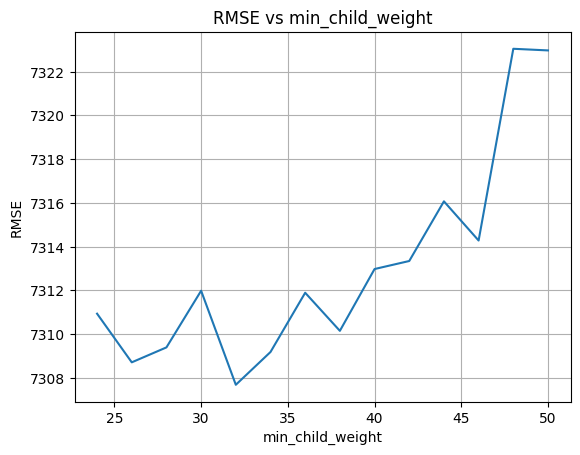

In [13]:
# Mejor min_child_weight
min_child_weight_best = min_child_weight_range[np.argmin(rmse_list)]
print(f'El mejor valor de min_child_weight es {min_child_weight_best}')
# Mejor error
rmse_best = np.min(rmse_list)
print(f'El mejor valor de RMSE es {rmse_best}')

# Graficar RMSE vs min_child_weight
plt.plot(min_child_weight_range, rmse_list)
plt.xlabel('min_child_weight')
plt.ylabel('RMSE')
plt.title('RMSE vs min_child_weight')
plt.grid()
plt.show()

In [14]:
# Que columnas hay en dataTesting que no hay en X_total
print(set(dataTesting.columns) - set(X_total.columns))

{'State_ CA', 'Model', 'Make_Acura'}


In [15]:
# Acortar rango de búsqueda en parámetros
n_estimators_range = list(range(120, 201, 20))
learning_rate_range = [0.1, 0.2, 0.3]
max_depth_range = list(range(4, 15, 2))
min_child_weight_range = list(range(26, 37, 2))

# Calibrar todas las combinaciones de los modelos
# Definición de variables para guardar los resultados
rmse_list = []

# Ciclo para evaluar n_estimators
for n_estimators in n_estimators_range:
    for rate in learning_rate_range:
        for depth in max_depth_range:
            for weight in min_child_weight_range:
                print(f'Probando con n_estimators={n_estimators}, learning_rate={rate}, max_depth={depth}, min_child_weight={weight}')
                # Crear el modelo
                model = XGBRegressor(n_estimators=n_estimators, learning_rate=rate, max_depth=depth, min_child_weight=weight, random_state=123, n_jobs=-1)
                # Entrenar el modelo
                model.fit(X_train, y_train)
                # Predecir
                y_pred = model.predict(X_test)
                # Calcular métricas
                rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
                print(f'RMSE={rmse}')
                # Guardar resultados
                rmse_list.append(rmse)

# Mejor error
rmse_best = np.min(rmse_list)
print(f'El mejor valor de RMSE es {rmse_best}')

# Crear dataframe con escenarios
results = pd.DataFrame()
index = 0

# Agregar escenarios
for estimator in n_estimators_range:
    for rate in learning_rate_range:
        for depth in max_depth_range:
            for weight in min_child_weight_range:
                results.loc[index, 'Estimators'] = estimator
                results.loc[index, 'Rate'] = rate
                results.loc[index, 'Depth'] = depth
                results.loc[index, 'Weight'] = weight
                results.loc[index, 'RMSE'] = rmse_list[index]
                index += 1

display(results.head())

# Obtener los menores RMSE
display(results[results['RMSE'] == results['RMSE'].min()])

Probando con n_estimators=120, learning_rate=0.1, max_depth=4, min_child_weight=26
RMSE=7547.707703916991
Probando con n_estimators=120, learning_rate=0.1, max_depth=4, min_child_weight=28
RMSE=7549.221990046179
Probando con n_estimators=120, learning_rate=0.1, max_depth=4, min_child_weight=30
RMSE=7547.9621183443405
Probando con n_estimators=120, learning_rate=0.1, max_depth=4, min_child_weight=32
RMSE=7547.782153572077
Probando con n_estimators=120, learning_rate=0.1, max_depth=4, min_child_weight=34
RMSE=7545.572765555608
Probando con n_estimators=120, learning_rate=0.1, max_depth=4, min_child_weight=36
RMSE=7548.8354683459775
Probando con n_estimators=120, learning_rate=0.1, max_depth=6, min_child_weight=26
RMSE=7404.771830030049
Probando con n_estimators=120, learning_rate=0.1, max_depth=6, min_child_weight=28
RMSE=7407.988162526001
Probando con n_estimators=120, learning_rate=0.1, max_depth=6, min_child_weight=30
RMSE=7409.465994563374
Probando con n_estimators=120, learning_rate

,Estimators,Rate,Depth,Weight,RMSE
0,120.0,0.1,4.0,26.0,7547.707704
1,120.0,0.1,4.0,28.0,7549.221990
2,120.0,0.1,4.0,30.0,7547.962118
3,120.0,0.1,4.0,32.0,7547.782154
4,120.0,0.1,4.0,34.0,7545.572766


,Estimators,Rate,Depth,Weight,RMSE
244,160.0,0.1,12.0,34.0,7303.633114


In [18]:
best_rmse = results[results['RMSE'] == results['RMSE'].min()]

n_estimators_best = best_rmse.iloc[0,0].astype(int)
learning_rate_best = best_rmse.iloc[0,1]
max_depth_best = best_rmse.iloc[0,2].astype(int)
min_child_weight_best = best_rmse.iloc[0,3].astype(int)

print(f'El mejor valor de n_estimators es {n_estimators_best}')
print(f'El mejor valor de learning_rate es {learning_rate_best}')
print(f'El mejor valor de max_depth es {max_depth_best}')
print(f'El mejor valor de min_child_weight es {min_child_weight_best}')

El mejor valor de n_estimators es 160
El mejor valor de learning_rate es 0.1
El mejor valor de max_depth es 12
El mejor valor de min_child_weight es 34


In [19]:
from xgboost import XGBRegressor
xgboost_reg = XGBRegressor(n_estimators=n_estimators_best, learning_rate=learning_rate_best, max_depth=max_depth_best, min_child_weight=min_child_weight_best, n_jobs=-1, random_state=123)
xgboost_reg.fit(X_total, y_total)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=34, missing=nan, monotone_constraints=None,
             n_estimators=160, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [20]:
# Predecir
y_pred = xgboost_reg.predict(dataTesting.drop(['Model', 'State_ CA','Make_Acura'], axis=1))

# Exportar resultados para Kaggle
y_pred = pd.DataFrame(y_pred, index=dataTesting.index, columns=['Price'])
y_pred.to_csv('submission_xgboost_2.csv', index_label='ID', header=['Price'])
y_pred.head()

,Price
ID,
0,21442.773438
1,32192.921875
2,23124.072266
3,7977.369629
4,28860.791016


In [3]:
import pandas as pd
state = 'FL'
model = 'F-150'
year = 2015
mileage = 100000
make = 'Jeep'

test = pd.DataFrame()
test.loc[0, 'Model'] = model
test.loc[0, 'State'] = state
test.loc[0, 'Year'] = year
test.loc[0, 'Mileage'] = mileage
test.loc[0, 'Make'] = make

test

,Model,State,Year,Mileage,Make
0,F-150,FL,2015.0,100000.0,Jeep


In [16]:
state = 'FL'
model = 'F-150'
year = 2015
mileage = 100000
make = 'Jeep'

test.loc[0,'Year'] = year
test.loc[0,'Mileage'] = mileage
test.loc[0,'State_'+state] = 1
test.loc[0,'Make_'+make] = 1
test.loc[0,'Model_'+model] = 1